# Crude Scheduler

Se utilizará el <i>framework</i> de __Pytorch__. 

## 1. Entorno Crude Scheduler

### 1.1. Establecer el entorno

En primer lugar cargaremos la librería __gym__ e inicializaremos el entorno.

In [1]:
if not ('isColab' in locals()):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        !pip install gymnasium
        !wget https://github.com/BaltiBoix/Scheduling/raw/master/tankEnvV2.py
        isColab = True
        from google.colab import drive
        drive.mount('/content/drive')
        drivePath = '/content/drive/MyDrive/Colab Notebooks/'
    else:
        print('Not running on CoLab')
        drivePath = ''

Not running on CoLab


In [2]:
import gymnasium as gym
from gymnasium.spaces import flatten as flat
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from collections import namedtuple, deque, OrderedDict
import os
import IPython.display
import sklearn
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

import tankEnvV2

env = gym.envs.make('crudeTanksEnv-v2')

C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 10)
  logger.warn(
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (2, 5)
  logger.warn(
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vec

In [3]:
print('Is torch cuda available?: {}'.format(torch.cuda.is_available()))

Is torch cuda available?: True


In [4]:
env.spec

EnvSpec(id='crudeTanksEnv-v2', entry_point=<class 'tankEnvV2.crudeTanksEnv'>, reward_threshold=700, nondeterministic=False, max_episode_steps=720, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='crudeTanksEnv', version=2)

In [5]:
def flatFixData(env, t=0, nCargos=6):
    n = nCargos - len(env.S.cargo.sched.keys())
    if n > 0:
        fSched = n*12*[0.0]
    else:
        fSched = []
    for k, v in env.S.cargo.sched.items():
        fSched += [k-t] + [v.vol] + v.toDict()['comp']
    fAssay = env.S.unit.assay.reshape(-1)
    return np.concatenate((fSched, fAssay, env.S.unit.volCutMax), axis=-1)

In [6]:
state0, data = env.reset()
state0 = np.concatenate((flatFixData(env, env.S.t), data['actionAvail'], flat(env.observation_space, state0)), axis=-1)
n_inputs = state0.shape[0]

C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float64, actual type: int32
  logger.warn(


In [7]:
crudeNames = np.array(['ARABIA LIGERO', 'BONNY LIGERO', 'BRASS RIVER', 'BRENT', 'CPC BLEND', 'DALIA', 
                       'PAZFLOR', 'SARIR', 'SIRTICA', 'ZAFIRO BLEND'])

assay = np.array(
    [[0.2083, 0.2503, 0.3046, 0.286 , 0.3979, 0.0596, 0.0843, 0.2039, 0.3133, 0.1962],
    [0.1639, 0.1502, 0.17  , 0.1457, 0.187 , 0.1094, 0.0978, 0.1249, 0.1546, 0.1427],
    [0.22  , 0.3191, 0.289 , 0.2297, 0.2281, 0.253 , 0.2845, 0.232, 0.2341, 0.2863],
    [0.2209, 0.2094, 0.1862, 0.2114, 0.1351, 0.3135, 0.2804, 0.2541, 0.1819, 0.2339],
    [0.1869, 0.071 , 0.0502, 0.1272, 0.0519, 0.2645, 0.253 , 0.1851, 0.1161, 0.1409]]
)
        
unitVolCutMax = np.array([0.25, 0.2, 0.4, 0.3, 0.2])

## Actor-Critic method


Basado en el ejemplo de pytorch:  

https://medium.com/geekculture/actor-critic-implementing-actor-critic-methods-82efb998c273

In [8]:
class AC_actor(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        super(AC_actor, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        self.actor = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.LayerNorm(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, self.n_outputs, bias=True),
            torch.nn.Softmax(dim=-1)
        )

        if self.device == 'cuda':
            self.actor.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
                                                                   patience=1000, factor=0.5, min_lr=1E-5, verbose=True)

    #Obtención de las probabilidades de las posibles acciones
    def get_action(self, state):
        state_t = torch.FloatTensor(state).to(device=self.device)
        return torch.distributions.Categorical(self.actor(state_t))


In [9]:
class AC_critic(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Params
        ======
        n_inputs: tamaño del espacio de estados
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        super(AC_critic, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        self.critic = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.LayerNorm(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1, bias=True)
        )

        if self.device == 'cuda':
            self.critic.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
                                                                   patience=1000, factor=0.5, min_lr=1E-5)
    
    def get_val(self, state):
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.critic(state_t)


### Definición del agente


In [10]:
class ACAgent:

    def __init__(self, env, assay, unitVolCutMax, seed, dnnet_actor, dnnet_critic, nblock=100, batch_size=32):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.assay = assay
        self.unitVolCutMax = unitVolCutMax
        self.seed = seed
        self.dnnet_actor = dnnet_actor
        self.dnnet_critic = dnnet_critic
        self.device = dnnet_actor.device
        self.nblock = nblock
        self.reward_threshold = env.spec.reward_threshold
        self.batch_size = batch_size
        self.initialize()

    def initialize(self):
        self.losses = []
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
    ######

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000, min_episodes=250):
        self.gamma = gamma

        episode = 0
        self.mean_rewards = -1000.0
        self.maxRewards = 0.0
        training = True
        print("Training...")
        while training:
            state, data = self.env.reset(seed=self.seed, assay=self.assay, unitVolCutMax=self.unitVolCutMax)
            actionAvail = data['actionAvail']
            state0 = np.concatenate((flatFixData(self.env), actionAvail, flat(self.env.observation_space, state)), axis=-1)
            episode_rewards = []
            gamedone = False
            t = 0
            I = 1
            batch_i = 0
            batch_loss_actor = []
            batch_loss_critic = []
            while gamedone == False:
                Prob = self.dnnet_actor.get_action(state0)
                action = Prob.sample()
                val = self.dnnet_critic.get_val(state0)
                prob_log = Prob.log_prob(action)

                new_state, reward, gamedone, _, info = self.env.step(action)
                actionAvail = info['actionAvail']
                new_state = np.concatenate((flatFixData(self.env, self.env.S.t), actionAvail, flat(self.env.observation_space, new_state)), axis=-1)

                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_rewards.append(reward)
                
                reward_t = torch.tensor([reward], device=self.device, dtype=torch.float)
                new_val = self.dnnet_critic.get_val(new_state)
                #if terminal state, next state val is 0
                if gamedone:
                    new_val = torch.tensor([0], device=self.device, dtype=torch.float)
                
                
                #calculate value function loss with MSE
                loss_critic = (reward_t + self.gamma * new_val - val).square()
                loss_critic *= I
                
                #calculate policy loss
                advantage = reward_t + self.gamma * new_val - val
                loss_actor = -prob_log * advantage.detach()
                loss_actor *= I
                
                batch_loss_actor.append(loss_actor)
                batch_loss_critic.append(loss_critic)
                batch_i += 1
        
                if batch_i == self.batch_size or gamedone:
                    #Backpropagate policy
                    batch_loss_actor_t = torch.stack(batch_loss_actor)
                    self.dnnet_actor.optimizer.zero_grad()

                    #Backpropagate value
                    batch_loss_critic_t = torch.stack(batch_loss_critic)
                    self.dnnet_critic.optimizer.zero_grad()
                    
                    batch_loss_critic_t.mean().backward()
                    batch_loss_actor_t.mean().backward()
                    
                    self.dnnet_actor.optimizer.step()
                    self.dnnet_actor.lr_sched.step(self.mean_rewards)
                    
                    self.dnnet_critic.optimizer.step()
                    self.dnnet_critic.lr_sched.step(self.mean_rewards)

                    batch_i = 0
                    batch_loss_actor = []
                    batch_loss_critic = []
                    
                    
                
                state0 = deepcopy(new_state)
                I *= self.gamma
                t += 1

            episode += 1
            n_steps = len(episode_rewards)

            self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas
            self.mean_rewards = np.mean(self.training_rewards[-self.nblock:])
            self.mean_training_rewards.append(self.mean_rewards)

            if self.training_rewards[-1] > self.maxRewards:
                self.maxRewards = self.training_rewards[-1]
                self.maxS = deepcopy(self.env.S)
                if min_episodes <  episode:
                    myfile = drivePath+'agentACDT_Best_Model.pth'
                    if os.path.isfile(myfile):
                        os.remove(myfile)
                    torch.save(self.main_network.state_dict(), myfile)

            # Comprobamos que todavía quedan episodios
            if episode >= max_episodes:
                training = False
                print('\nEpisode limit reached.')
                break

            if episode > 100 and episode % 100 == 0:
                self.plot_rewards()

            print("\rEpisode {:3d} Mean Rewards {:.2f} Last Reward {:.2f}  Loss actor {:.4f}  Loss critic {:.4f}\t\t".format(
                episode, self.mean_rewards, np.mean(self.training_rewards[-1]), loss_actor.item(), loss_critic.item()), end="")

            # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
            if self.mean_rewards >= self.reward_threshold and episode > self.nblock:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(
                    episode))
                break

    def plot_rewards(self):
       
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.env.spec.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()


### Entrenamiento


In [11]:
lr_actor = 0.0001    #Velocidad de aprendizaje   0.005
lr_critic = 0.005    #Velocidad de aprendizaje   0.005
GAMMA = 0.99         #Valor gamma de la ecuación de Bellman
NBLOCK = 100         #Número de steps para rellenar el buffer
MAX_EPISODES = 5000  #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)
BATCH_SIZE = 32

In [12]:
ACa = AC_actor(env, n_inputs, learning_rate=lr_actor, device='cuda')
f = drivePath+'agentACDT_Best_Model.pth'
if os.path.isfile(f):
    ACa.load_state_dict(torch.load(f))

In [13]:
ACc = AC_critic(env, n_inputs, learning_rate=lr_critic, device='cuda')

In [14]:
AC_agent = ACAgent(env, assay, unitVolCutMax, 200560, ACa, ACc, NBLOCK, BATCH_SIZE)

In [15]:
%%time

AC_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES)

Training...


C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'torch.Tensor'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float64, actual t

Episode  40 Mean Rewards 206.58 Last Reward 204.89 n steps 720  Loss actor -0.1265  Loss critic 1.0300		

KeyboardInterrupt: 

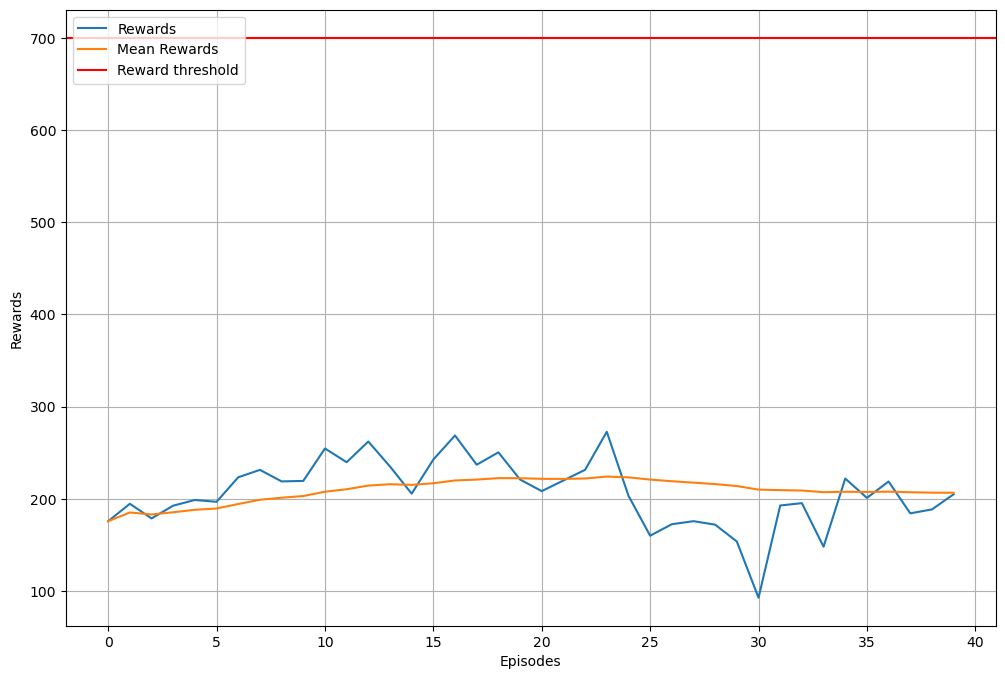

In [16]:
AC_agent.plot_rewards()

In [18]:
myfile = drivePath+'agentAC_Trained_Model.pth'
if os.path.isfile(myfile):
    os.remove(myfile)
torch.save(ACa.state_dict(), myfile)

n:  720   reward: 215.29


C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\gymnasium\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(




CPU times: total: 1.98 s
Wall time: 2.01 s


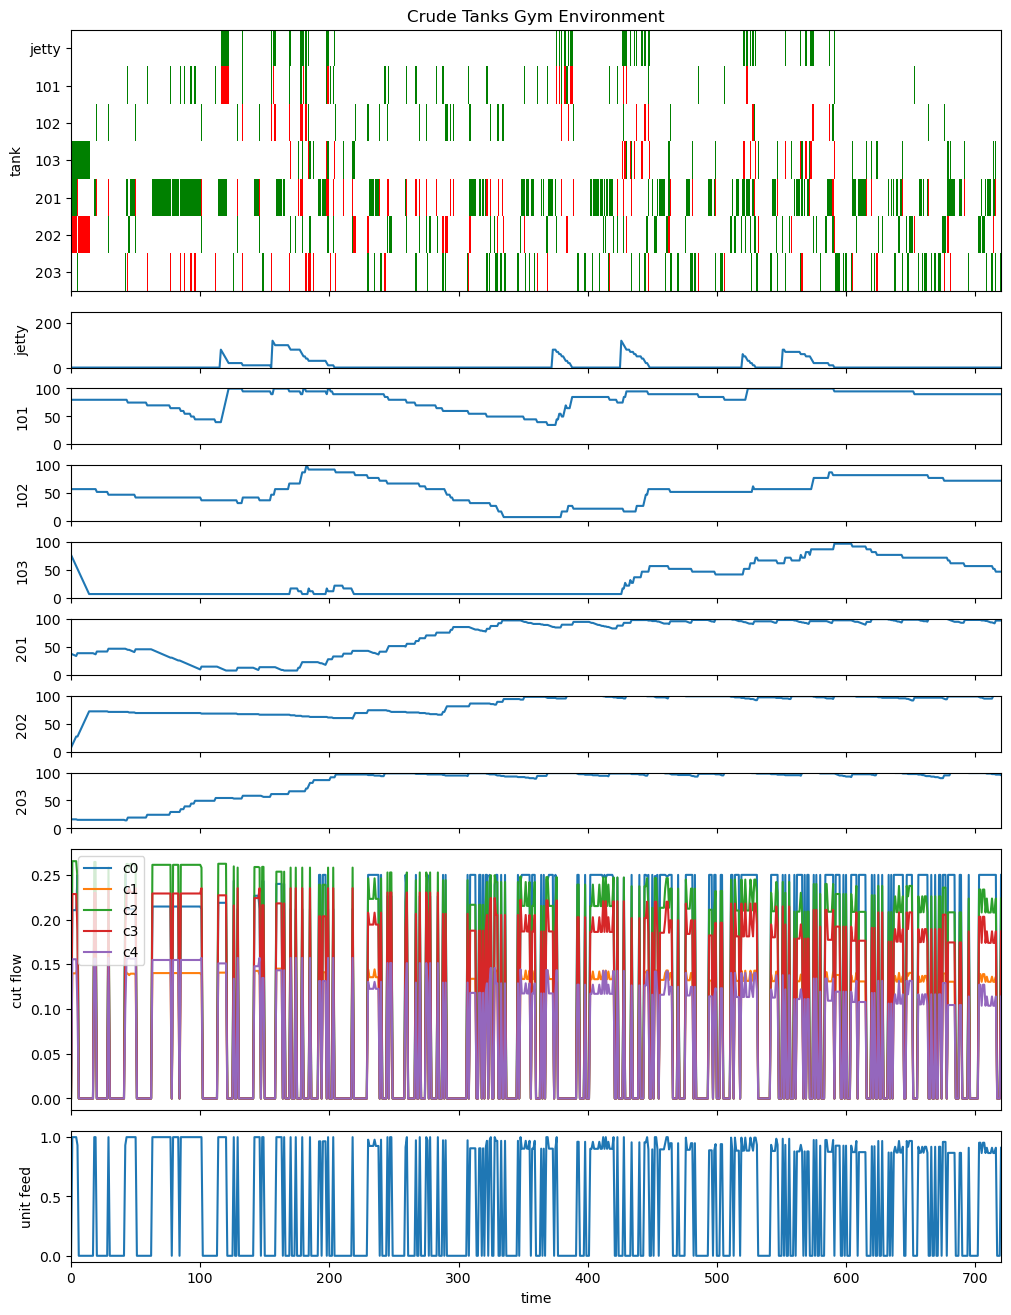

In [19]:
%%time

env = gym.envs.make("crudeTanksEnv-v2")
seed = 200560
AC = AC_actor(env, n_inputs, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

state0, data = env.reset(seed=seed, assay=assay, unitVolCutMax=unitVolCutMax)
actionAvail = data['actionAvail']
state0 = np.concatenate((flatFixData(env), actionAvail, flat(env.observation_space, state0)), axis=-1)
done = False
episode_reward = 0
n = 0
action_list = []
while not done:
    Prob = AC.get_action(state0)
    action = Prob.sample()
    new_state, reward, gamedone, _, info = env.step(action)
    actionAvail = info['actionAvail']
    new_state = np.concatenate((flatFixData(env, env.S.t), actionAvail, flat(env.observation_space, new_state)), axis=-1)
    episode_reward += reward
    n += 1
    state0 = deepcopy(new_state)
    if n >= env.spec.max_episode_steps:
        done = True

print('n: {:4d}   reward: {:4.2f}'.format(n, episode_reward))
env.render()
print('\n')

In [24]:
%%time

env = gym.envs.make("crudeTanksEnv-v2")

AC = AC_actor(env, n_inputs, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

reward_list = []
n_list = []
for n_episodes in range(20):
    state0, data = env.reset(seed=seed, assay=assay, unitVolCutMax=unitVolCutMax)
    actionAvail = data['actionAvail']
    state0 = np.concatenate((flatFixData(env), actionAvail, flat(env.observation_space, state0)), axis=-1)
    done = False
    episode_reward = 0
    n = 0
    action_list = []
    while not done:
        Prob = AC.get_action(state0)
        action = Prob.sample()
        new_state, reward, gamedone, _, info = env.step(action)
        actionAvail = info['actionAvail']
        new_state = np.concatenate((flatFixData(env, env.S.t), actionAvail, flat(env.observation_space, new_state)), axis=-1)
        episode_reward += reward
        n += 1
        state0 = deepcopy(new_state)
        if n >= env.spec.max_episode_steps:
            done = True

    print('{:2d} n: {:4d}   reward: {:4.2f}'.format(n_episodes+1, n, episode_reward))
    reward_list.append(episode_reward)
print('\n')

 1 n:  720   reward: 232.22
 2 n:  720   reward: 181.38
 3 n:  720   reward: 229.21
 4 n:  720   reward: 223.69
 5 n:  720   reward: 217.37
 6 n:  720   reward: 231.21
 7 n:  720   reward: 186.63
 8 n:  720   reward: 214.21
 9 n:  720   reward: 217.62
10 n:  720   reward: 202.14
11 n:  720   reward: 209.06
12 n:  720   reward: 202.10
13 n:  720   reward: 243.80
14 n:  720   reward: 219.14
15 n:  720   reward: 234.27
16 n:  720   reward: 217.44
17 n:  720   reward: 200.38
18 n:  720   reward: 191.69
19 n:  720   reward: 195.02
20 n:  720   reward: 204.66


CPU times: total: 28.5 s
Wall time: 28.7 s


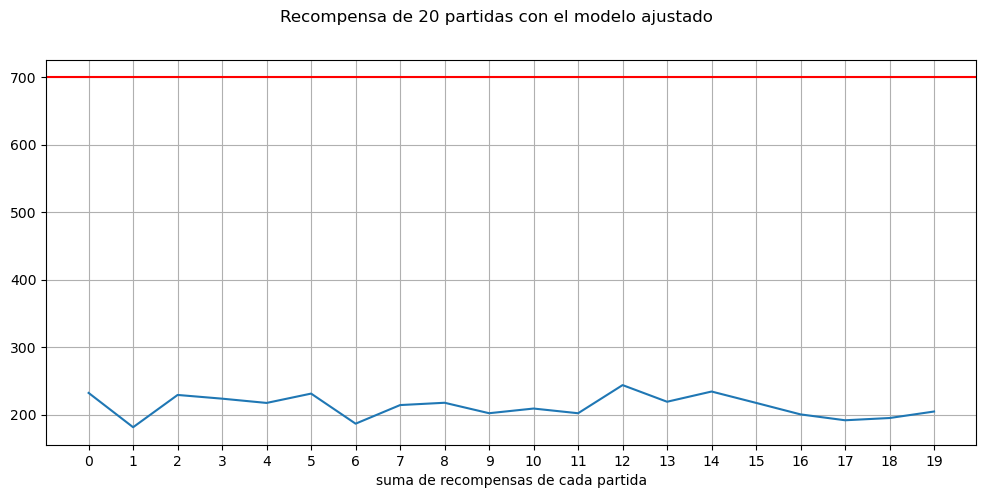

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))

fig.suptitle('Recompensa de 20 partidas con el modelo ajustado')

ax.plot(reward_list)
ax.axhline(y=env.spec.reward_threshold, color='r', linestyle='-')
ax.set_xlabel('suma de recompensas de cada partida')
ax.set_xticks(range(20))
ax.grid()

plt.show()